# Growth word competition prediction
In which we predict the competition results of paired growth words, according to different social and semantic factors.

In [384]:
from __future__ import division
import pandas as pd
import matplotlib
% matplotlib inline
import matplotlib.pyplot as plt
import sys
if('..' not in sys.path):
    sys.path.append('..')
from data_processing.data_handler import get_default_vocab

## Load data

In [31]:
tf_2015_2016 = pd.read_csv('../../data/frequency/2015_2016_tf_norm.tsv', sep='\t', index_col=0)
tf_2014_2015 = pd.read_csv('../../data/frequency/2014_2015_tf_norm.tsv', sep='\t', index_col=0)
vocab = get_default_vocab()
print(len(vocab))
tf_2014_2015 = tf_2014_2015.loc[vocab]
tf_2014_2015.fillna(0, inplace=True)

100000


In [32]:
tf_2014_2015.shape

(100000, 12)

Figure out which words didn't exist in 2014-2015.

In [273]:
tf_2014_2015_mean = tf_2014_2015.mean(axis=1)
tf_2014_2015_high_freq = tf_2014_2015_mean[tf_2014_2015_mean > 0.]
print(tf_2014_2015_high_freq.shape)

(99950,)


In [188]:
growth_percentile = 90
tf_growth_2015_2016 = pd.read_csv('../../data/frequency/2015_2016_tf_norm_correls.tsv', sep='\t', index_col=0)
growth_lower = pd.np.percentile(tf_growth_2015_2016['correl'], growth_percentile)
growth_word_correls = tf_growth_2015_2016[tf_growth_2015_2016['correl'] >= growth_lower]
print(growth_word_correls.head())
print('%d growth words'%(len(growth_word_correls)))

           correl    pvalue
removed  0.797203  0.001900
s        0.622378  0.030676
lol      0.692308  0.012593
issue    0.818182  0.001143
support  0.853147  0.000418
10237 growth words


In [275]:
# want growth words that were not present or minimally present in 2014-2015
growth_words = list(set(growth_word_correls.index) - set(tf_2014_2015_high_freq.index))
print('%d growth words that were not present in 2014-2015'%(len(growth_words)))
# print(pd.np.random.choice(growth_words, size=100, replace=False))
print(growth_words)

5 growth words that were not present in 2014-2015
['drumpf', 'sysupdater', 'valkorion', 'skillpower', 'idlz']


This sample size is too small. What if we increase the lower limit to count as "high frequency" in 2014-2015?

In [277]:
lower_percentile = 10
# numeric cutoff
tf_upper_bound = pd.np.percentile(tf_2014_2015.mean(axis=1), lower_percentile)
print(tf_upper_bound)
tf_2014_2015_high_freq = tf_2014_2015_mean[tf_2014_2015_mean > tf_upper_bound]
growth_words = list(set(growth_word_correls.index) - set(tf_2014_2015_high_freq.index))
print('%d growth words that were not present in 2014-2015'%(len(growth_words)))
print(pd.np.random.choice(growth_words, size=100, replace=False))

1.22977385333e-07
2054 growth words that were not present in 2014-2015
['julianna' 'homebuyers' 'deadmans' 'poza' 'jere' 'funes' 'zeruiah'
 'howlers' 'yachiru' 'kudo' 'ficar' 'przed' 'thefinebros' 'phaeton'
 'skools' 'newcomb' 'mushin' 'tila' 'davina' 'ncwest' 'respek' 'starviper'
 'diebold' 'poti' 'andromedon' 'windfalls' 'kallocain' 'philandering'
 'uldaman' 'zellner' 'puljujarvi' 'lafiel' 'albo' 'bodying' 'raijin' 'wlb'
 'sephirot' 'artamiel' 'scatterer' 'telvin' 'empt' 'opx' 'manno'
 'unfavorables' 'posle' 'zapatistas' 'laing' 'autothrusters' 'skrilla'
 'gachas' 'presa' 'embered' 'hikou' 'saiyaman' 'hilldog' 'dogwhistle'
 'scrobbles' 'rallys' 'jfb' 'rafflesia' 'laquon' 'soundbytes' 'vulfpeck'
 'buting' 'gostisbehere' 'pragmatists' 'osweiller' 'berried' 'toah' 'ryoma'
 'anotha' 'murr' 'mogami' 'sekrit' 'beltless' 'gbatemp' 'galavant'
 'actblue' 'fuckbois' 'axelrod' 'memery' 'bodyblock' 'deakin' 'canvassed'
 'dardoch' 'blathers' 'ultrawides' 'youpi' 'passar' 'hil' 'varmilo'
 'genroku

Mostly non-English but also misspellings and actual new words?? `dogwhistle` is new.

## Set up prediction
Now we pair growth words into competitors based on their semantic similarity. After each pairing, we remove both words from the pool to prevent a word being chosen twice.

For each growth word $g_{1}$ in $G$, $g_{2}=argmax_{g_{w} \in G, w \neq 1}(sim(g_{1}, g_{w}))$.

Once we have the pairs, we predict which word in the pair will have a higher frequency at $t_{11}$ based on the following statistics at $t_{0}$:

- frequency $f$
- user diffusion $D_{U}$
- subreddit diffusion $D_{S}$
- thread diffusion $D_{T}$
- bigram residuals (i.e. context diversity) $C_{2}$
- trigram residuals (i.e. context diversity) $C_{3}$
- nearest neighbor distance $N$

## Compute similarity between growth words
Compute cosine similarity between all growth words based on their word embeddings at the initial timestep (`2015-06`).

In [278]:
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
# embed_file = '../../data/embeddings/2015-06_wang2vec_100_5_embeddings'
embed_file = '../../data/embeddings/2015-06_word2vec_100_5_embeddings'
embeddings = Word2Vec.load_word2vec_format(embed_file, binary=True)
embed_vocab = list(set(growth_words) & set(embeddings.vocab.keys()))
print('%d growth words in embeddings'%(len(embed_vocab)))
growth_embeddings = pd.concat([pd.Series(embeddings[v]) for v in embed_vocab], axis=1).transpose()
growth_sims = cosine_similarity(growth_embeddings)
growth_sims = pd.DataFrame(growth_sims, index=embed_vocab, columns=embed_vocab)
print(growth_sims.head())

1853 growth words in embeddings
              penelo  safespace  mechanicum      hatr     vezes  unsworth  \
penelo      1.000000   0.087625    0.275544  0.329760  0.289798  0.437758   
safespace   0.087625   1.000000    0.123191  0.294246  0.134558  0.142183   
mechanicum  0.275544   0.123191    1.000000  0.376710  0.138683  0.337239   
hatr        0.329760   0.294246    0.376710  1.000000  0.488743  0.636947   
vezes       0.289798   0.134558    0.138683  0.488743  1.000000  0.519121   

                negi      cias  sumproduct  shotgunner    ...     monokuma  \
penelo      0.513899  0.329550    0.143296    0.128509    ...     0.322795   
safespace   0.045793  0.189098    0.062372    0.044493    ...     0.093976   
mechanicum  0.313194  0.291875    0.136632    0.082957    ...     0.238721   
hatr        0.372717  0.365477    0.278092    0.211761    ...     0.294034   
vezes       0.277223  0.469321    0.186924   -0.000105    ...     0.197462   

               eakin  biblegateway  

## Pair growth words

Pair words according to semantic similarity.

In [423]:
N = int(len(growth_words) / 2)
vocab = list(growth_words)
def get_pairs_no_replace(sims, vocab, size):
    g_sims = sims.ix[vocab, vocab]
    g_pairs = []
    g_words = set()
    while(len(g_pairs) < size):
        g1 = pd.np.random.choice(vocab, 1, replace=False)[0]
        g2_list = g_sims.loc[g1].sort_values(inplace=False, ascending=False)[1:].index.tolist()
        for g in g2_list:
            if(g not in g_words):
                g2 = g
                break
        g_pair = (g1, g2)
        g_pairs.append(g_pair)
        g_words.add(g1)
        g_words.add(g2)
    return g_pairs
all_pairs_no_replace = get_pairs_no_replace(growth_sims, vocab, N)
pd.np.random.shuffle(all_pairs_no_replace)
top_k = 20
print('got %d sample pairs %s'%(top_k, all_pairs_no_replace[:top_k]))

got 20 sample pairs [('kdot', 'nghtmre'), ('postmarked', 'backdated'), ('reprojection', 'trinus'), ('xul', 'rafflesia'), ('prioritises', 'ssbs'), ('locura', 'vezes'), ('spaa', 'luchs'), ('ursus', 'cannoneer'), ('ringplus', 'gigapower'), ('titi', 'pizzi'), ('torchy', 'kalitas'), ('skrilla', 'schmeckles'), ('gopers', 'obstructionists'), ('mcginty', 'bolling'), ('begge', 'syns'), ('btcc', 'wehrlein'), ('idioteque', 'httt'), ('flordia', 'bernadino'), ('disenfranchises', 'superdelegate'), ('ehrenreich', 'raskin')]


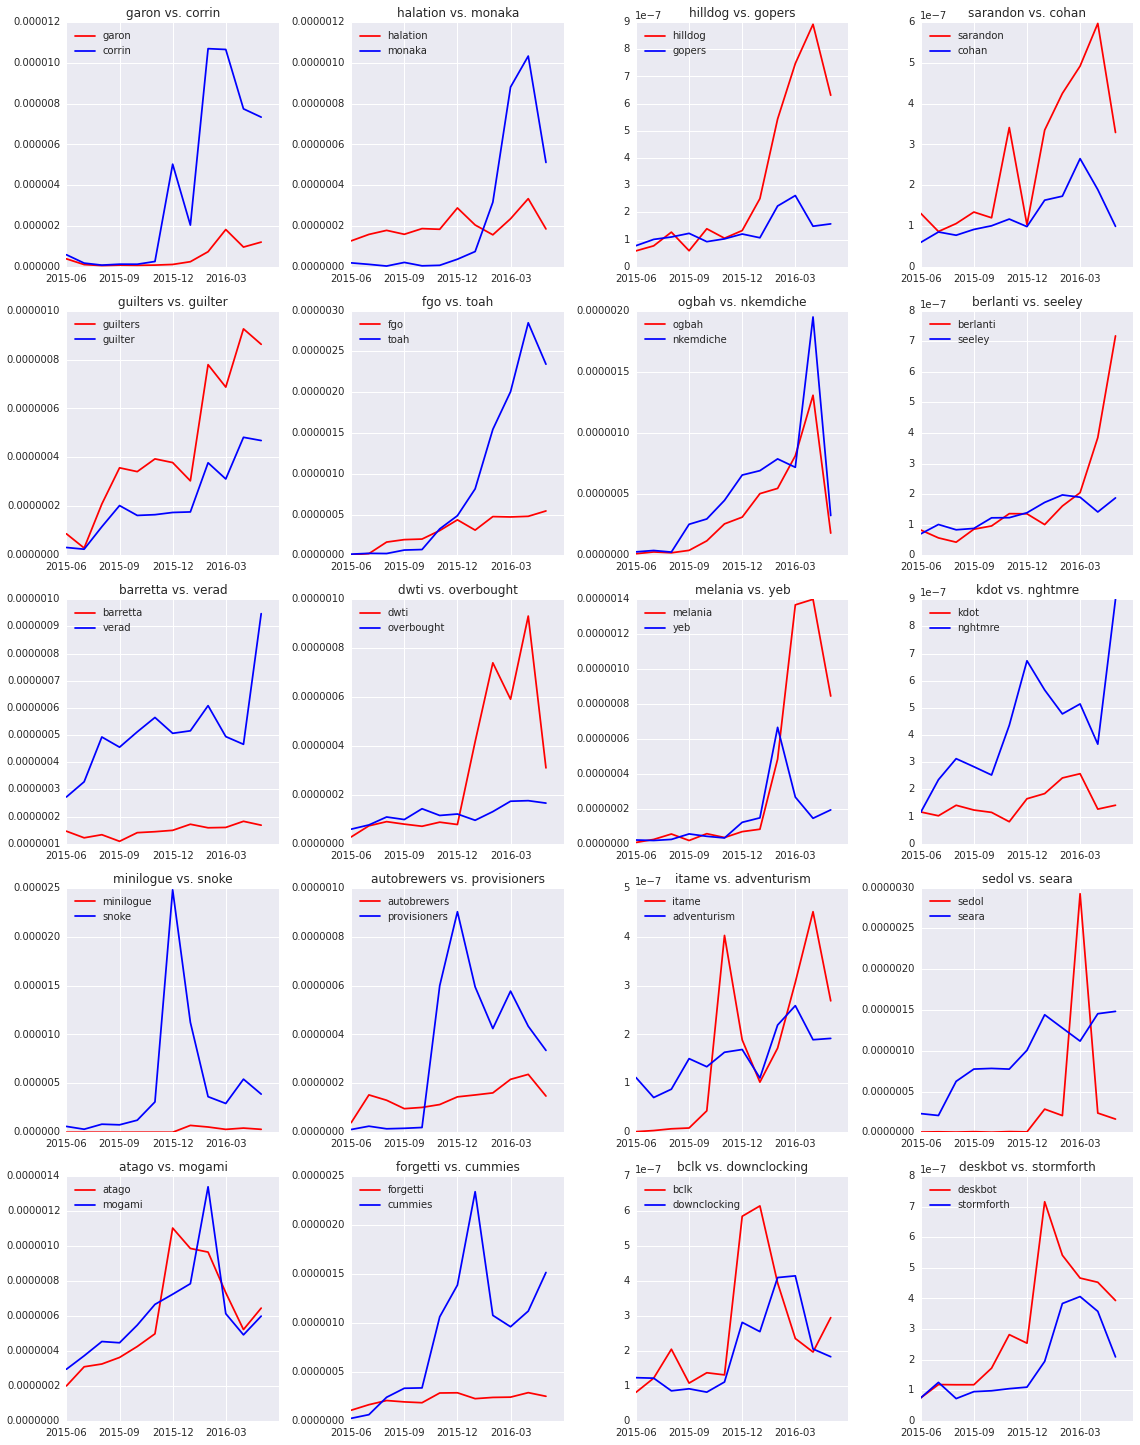

In [427]:
# plot example growth word pairs
top_k = 20
pd.np.random.shuffle(all_pairs_no_replace)
sample_pairs = all_pairs_no_replace[:top_k]
cols = 4
rows = int(len(sample_pairs) / cols) + 1
all_dates = sorted(tf_2015_2016.columns)
x_positions = range(len(all_dates))
xticks, xlabels = zip(*zip(x_positions, all_dates)[::3])
plt.figure(figsize=(cols * size, rows * size))
for i, (w1, w2) in enumerate(sample_pairs):
    plt.subplot(rows, cols, i+1)
    plt.plot(x_positions, tf_2015_2016.loc[w1], 'r', label=w1)
    plt.plot(x_positions, tf_2015_2016.loc[w2], 'b', label=w2)
    plt.title('%s vs. %s'%(w1, w2))
    plt.legend(loc='upper left')
    plt.xticks(xticks, xlabels)
plt.tight_layout()
plt.show()

There's a few cases of crossover but generally there's a clear winner after the first few weeks.

## Gather predictor variables

Extract all the predictor statistics and make sure they all have the same vocabulary.

In [446]:
tf_0 = tf_2015_2016.ix[:,0]
user_diffusion = pd.read_csv('../../data/frequency/2015_2016_user_diffusion.tsv', sep='\t', index_col=0).ix[:,0]
sub_diffusion = pd.read_csv('../../data/frequency/2015_2016_subreddit_diffusion.tsv', sep='\t', index_col=0).ix[:,0]
thread_diffusion = pd.read_csv('../../data/frequency/2015_2016_thread_diffusion.tsv', sep='\t', index_col=0).ix[:,0]
bigram_resids = pd.read_csv('../../data/frequency/2015_2016_2gram_resids.tsv', sep='\t', index_col=0).ix[:,0]
trigram_resids = pd.read_csv('../../data/frequency/2015_2016_3gram_resids.tsv', sep='\t', index_col=0).ix[:,0]
nearest_sim = pd.read_csv('../../data/embeddings/2015_2016_wang2vec_top_1_sim_niche_similarities.tsv', 
                           sep='\t', index_col=0).ix[:,0]

In [447]:
all_stats = [tf_0, user_diffusion, sub_diffusion, thread_diffusion, bigram_resids, trigram_resids, nearest_sim]
stat_names = ['f', 'DU', 'DS', 'DT', 'C2', 'C3', 'N']
vocab = set(get_default_vocab())
clean_stats = []
for n, s in zip(stat_names, all_stats):
    s = s.loc[vocab]
    s.fillna(0, inplace=True)
    s_smooth = 1e-1 * s[s > 0].min()
    s = s + s_smooth
    clean_stats.append(s)
all_stats = clean_stats

In [372]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
def get_data(pairs, stats, stat_names):
    data = {}
    w1, w2 = zip(*pairs)
    w1 = list(w1)
    w2 = list(w2)
#     print(w1)
#     print(w2)
    for stat_name, stat in zip(stat_names, stats):
#         print('processing stat %s'%(stat_name))
        w1_vals = stat.loc[w1].values
        w2_vals = stat.loc[w2].values
        if(stat_name == 'C2' or stat_name == 'C3'):
            data_s = w1_vals - w2_vals
        else:
            data_s = w1_vals / w2_vals
        data[stat_name] = data_s
    index = ['%s_%s'%(w1, w2) for w1, w2 in pairs]
    data = pd.DataFrame(data, index=index)
    # make sure that data is in right order
    data = data[stat_names]
    return data
X_data = get_data(all_pairs_no_replace, all_stats, stat_names)
pair_names = X_data.index.tolist()
scaler = MinMaxScaler()
X_data = scaler.fit_transform(X_data)
X_data = pd.DataFrame(X_data, index=pair_names, columns=stat_names)
w1, w2 = zip(*all_pairs)
w1 = list(w1)
w2 = list(w2)
Y_data = ((tf_11.loc[w1].values / tf_11.loc[w2].values) > 1.).astype(int)
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data)

In [304]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
lr = LogisticRegression()
lr.fit(X_train, Y_train)
Y_pred = lr.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(Y_test, Y_pred)
precision = precision[1]
recall = recall[1]
fscore = fscore[1]
support = support[1]
print('precision: %.3f'%(precision*100))
print('recall: %.3f'%(recall*100))
print('F-score: %.3f'%(fscore*100))
print('support: %.3f'%(support*100))

precision: 48.148
recall: 21.849
F-score: 30.058
support: 11900.000


In [305]:
from sklearn.model_selection import cross_val_score
lr = LogisticRegression()
scores = cross_val_score(lr, X_data, Y_data, cv=5)
print(scores)
print(pd.np.mean(scores))

[ 0.51456311  0.5         0.49514563  0.48780488  0.50490196]
0.500483115339


Overall a pretty weak performance. What if we only provide some of the predictors?

In [306]:
X_combos = [
    ['f'], 
    ['f', 'DS', 'DU', 'DT'],
    ['f', 'C2', 'C3', 'N'],
    ['f', 'DS', 'DU', 'DT', 'C2', 'C3', 'N'],
]
for combo in X_combos:
    X_data_ = X_data[combo]
    scores = cross_val_score(lr, X_data_, Y_data, cv=10)
    print('combo %s got scores %s => %.3f'%('/'.join(combo), str(scores), pd.np.mean(scores)))

combo f got scores [ 0.51923077  0.51923077  0.5         0.50485437  0.50980392  0.50980392
  0.51960784  0.51960784  0.51960784  0.5       ] => 0.512
combo f/DS/DU/DT got scores [ 0.5         0.51923077  0.50961538  0.50485437  0.50980392  0.50980392
  0.5         0.51960784  0.51960784  0.51960784] => 0.511
combo f/C2/C3/N got scores [ 0.5         0.55769231  0.50961538  0.51456311  0.49019608  0.51960784
  0.52941176  0.44117647  0.48039216  0.51960784] => 0.506
combo f/DS/DU/DT/C2/C3/N got scores [ 0.50961538  0.54807692  0.50961538  0.51456311  0.5         0.49019608
  0.52941176  0.44117647  0.48039216  0.51960784] => 0.504


Seems like diffusion hurts the least.

Let's investigate the relative influence of the different factors on word success.

In [307]:
from statsmodels.discrete.discrete_model import Logit
logit = Logit(Y_data, X_data)
results = logit.fit(method='bfgs', maxiter=1000)
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.686872
         Iterations: 76
         Function evaluations: 79
         Gradient evaluations: 79
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1027
Model:                          Logit   Df Residuals:                     1020
Method:                           MLE   Df Model:                            6
Date:                Tue, 28 Mar 2017   Pseudo R-squ.:                0.008022
Time:                        13:12:35   Log-Likelihood:                -705.42
converged:                       True   LL-Null:                       -711.12
                                        LLR p-value:                   0.07654
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
f              1.3538      1.632      

Most of the predictors have little to no effect except for $D_{S}$ and (maybe) $N$. This is probably a product of the word-pairing process.

## Pair growth words with replacement
This will cause some words to be over-represented but will also cut down on the number of falsely-connected growth pairs.

In [429]:
vocab = list(growth_words)
N = len(vocab)
def get_pairs_replace(sims, vocab, size):
    g_sims = sims.ix[vocab, vocab]
    g_pairs = []
    for g1 in vocab:
        g2_list = g_sims.loc[g1].sort_values(inplace=False, ascending=False)[1:].index.tolist()
        g2 = g2_list[0]
        g_pair = (g1, g2)
        g_pairs.append(g_pair)
    return g_pairs
all_pairs_replace = get_pairs_replace(growth_sims, vocab, N)
pd.np.random.shuffle(all_pairs_replace)
top_k = 20
print('got %d sample pairs %s'%(top_k, all_pairs_replace[:top_k]))
# make sure that we aren't oversampling words
w1, w2 = zip(*all_pairs)
print('%d words paired with %d unique matches'%(len(set(w1)), len(set(w2))))

got 20 sample pairs [('uwp', 'webui'), ('whoolies', 'brooo'), ('shatty', 'fabbri'), ('arlene', 'zellner'), ('hote', 'facut'), ('astralis', 'skywalkers'), ('schuyler', 'pierson'), ('teebo', 'bariss'), ('heve', 'fant'), ('mhx', 'dsiii'), ('casteism', 'nativism'), ('deciders', 'shillary'), ('blundell', 'bullard'), ('yammy', 'starrk'), ('gamethrowing', 'multiboxer'), ('ootb', 'homeseer'), ('guus', 'hiddink'), ('moonrocks', 'ephenidine'), ('yachiru', 'kisuke'), ('issth', 'inai')]
1307 words paired with 741 unique matches


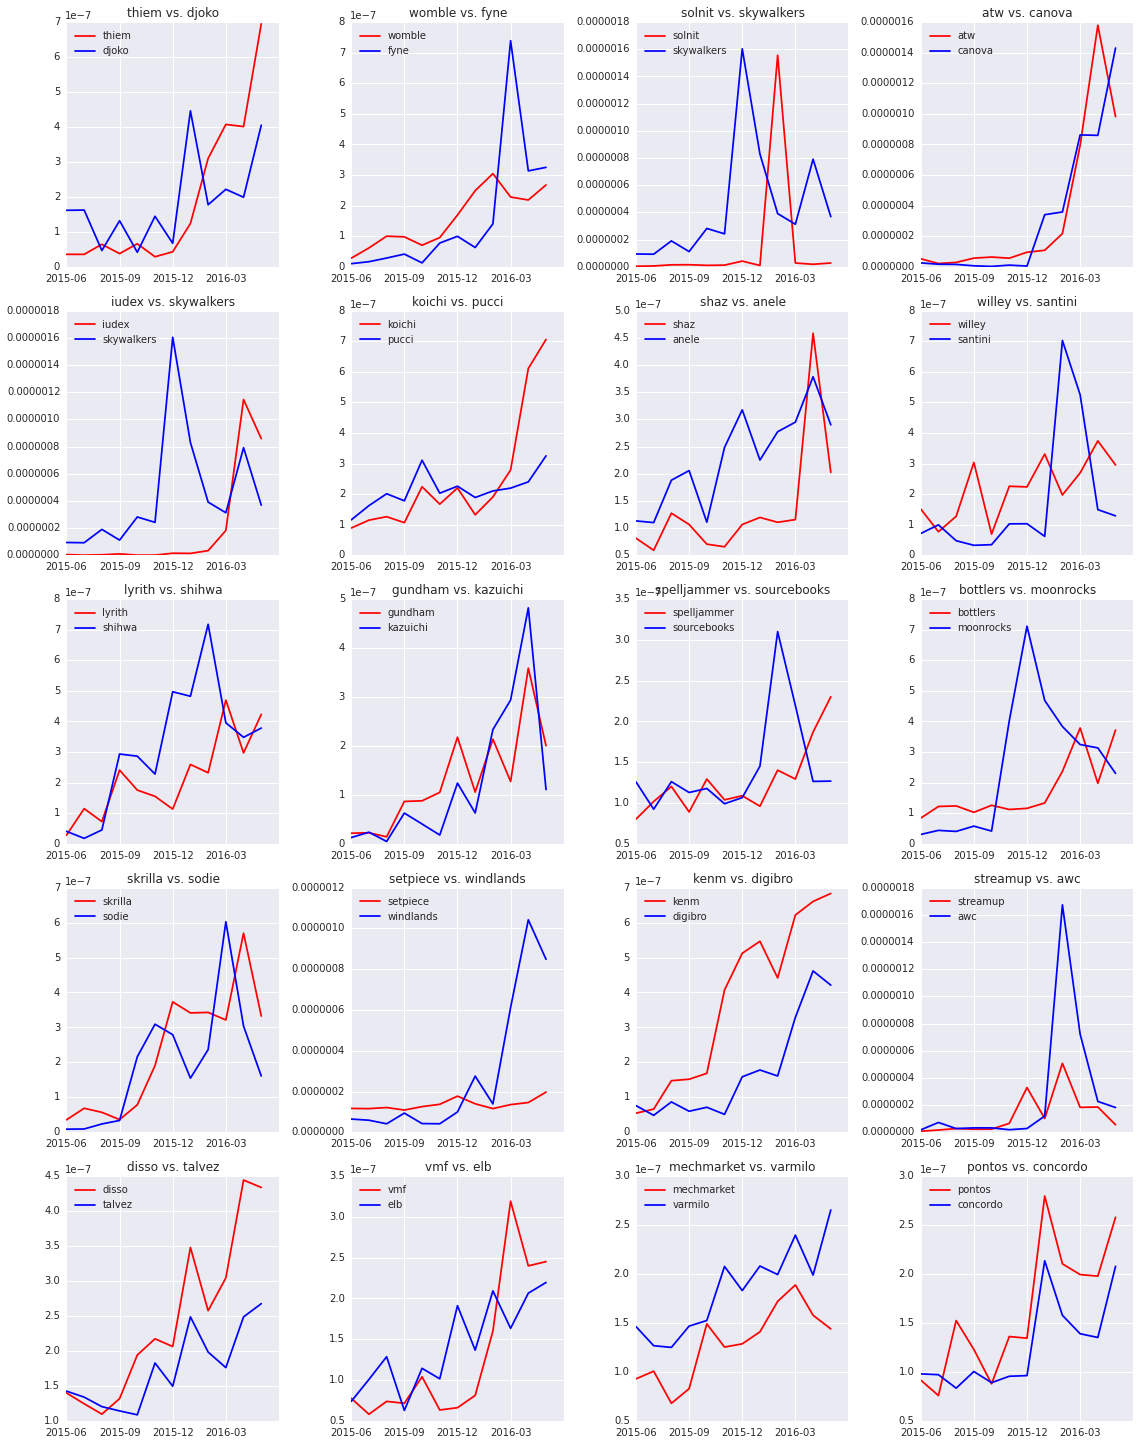

In [430]:
# plot example growth word pairs
top_k = 20
pd.np.random.shuffle(all_pairs_replace)
sample_pairs = all_pairs_replace[:top_k]
cols = 4
rows = int(len(sample_pairs) / cols) + 1
all_dates = sorted(tf_2015_2016.columns)
x_positions = range(len(all_dates))
xticks, xlabels = zip(*zip(x_positions, all_dates)[::3])
plt.figure(figsize=(cols * size, rows * size))
for i, (w1, w2) in enumerate(sample_pairs):
    plt.subplot(rows, cols, i+1)
    plt.plot(x_positions, tf_2015_2016.loc[w1], 'r', label=w1)
    plt.plot(x_positions, tf_2015_2016.loc[w2], 'b', label=w2)
    plt.title('%s vs. %s'%(w1, w2))
    plt.legend(loc='upper left')
    plt.xticks(xticks, xlabels)
plt.tight_layout()
plt.show()

There seems to be more crossover/co-evolution here.

In [448]:
X_data = get_data(all_pairs_replace, all_stats, stat_names)
pair_names = X_data.index.tolist()
scaler = MinMaxScaler()
X_data = scaler.fit_transform(X_data)
X_data = pd.DataFrame(X_data, index=pair_names, columns=stat_names)
w1, w2 = zip(*all_pairs)
w1 = list(w1)
w2 = list(w2)
Y_data = ((tf_11.loc[w1].values / tf_11.loc[w2].values) > 1.).astype(int)

In [449]:
X_combos = [
    ['f'], 
    ['f', 'DS', 'DU', 'DT'],
    ['f', 'C2', 'C3', 'N'],
    ['f', 'DS', 'DU', 'DT', 'C2', 'C3', 'N'],
]
for combo in X_combos:
    lr = LogisticRegression()
    X_data_ = X_data[combo]
    scores = cross_val_score(lr, X_data_, Y_data, cv=10)
    print('combo %s got scores %s => %.3f'%('/'.join(combo), str(scores), pd.np.mean(scores)))

combo f got scores [ 0.50485437  0.52912621  0.51941748  0.52427184  0.52427184  0.52195122
  0.51707317  0.51707317  0.52195122  0.51470588] => 0.519
combo f/DS/DU/DT got scores [ 0.50970874  0.49514563  0.52912621  0.51456311  0.52427184  0.52195122
  0.52195122  0.51707317  0.52195122  0.5245098 ] => 0.518
combo f/C2/C3/N got scores [ 0.50970874  0.51941748  0.51941748  0.52427184  0.52427184  0.50731707
  0.52195122  0.51707317  0.52195122  0.51960784] => 0.518
combo f/DS/DU/DT/C2/C3/N got scores [ 0.49029126  0.49514563  0.52912621  0.52912621  0.51456311  0.50731707
  0.52195122  0.51707317  0.52682927  0.5245098 ] => 0.516


In [311]:
logit = Logit(Y_data, X_data)
results = logit.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.682564
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 2054
Model:                          Logit   Df Residuals:                     2047
Method:                           MLE   Df Model:                            6
Date:                Tue, 28 Mar 2017   Pseudo R-squ.:                 0.01408
Time:                        13:13:16   Log-Likelihood:                -1402.0
converged:                       True   LL-Null:                       -1422.0
                                        LLR p-value:                 4.476e-07
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
f             -0.8709      0.754     -1.155      0.248        -2.348     0.606
DU             0.8720      0.

$D_{T}$ has negative correlation with word success, and $C_{3}$ has positive correlation. Maybe $C2$ has too much overlap (e.g. double-counting bigrams) to be useful.

## Test different timesteps
Try training data drawn from $t=1$ to $t=10$. We predict that data closer to $t=11$ will be more accurate.

In [374]:
tf = pd.read_csv('../../data/frequency/2015_2016_tf_norm.tsv', sep='\t', index_col=0)
user_diffusion = pd.read_csv('../../data/frequency/2015_2016_user_diffusion.tsv', sep='\t', index_col=0)
sub_diffusion = pd.read_csv('../../data/frequency/2015_2016_subreddit_diffusion.tsv', sep='\t', index_col=0)
thread_diffusion = pd.read_csv('../../data/frequency/2015_2016_thread_diffusion.tsv', sep='\t', index_col=0)
bigram_resids = pd.read_csv('../../data/frequency/2015_2016_2gram_resids.tsv', sep='\t', index_col=0)
trigram_resids = pd.read_csv('../../data/frequency/2015_2016_3gram_resids.tsv', sep='\t', index_col=0)
nearest_sims = pd.read_csv('../../data/embeddings/2015_2016_word2vec_top_10_sim_niche_similarities.tsv', 
                          sep='\t', index_col=0)
all_stats_full = [tf, user_diffusion, sub_diffusion, thread_diffusion, bigram_resids, trigram_resids, nearest_sims]

In [376]:
stat_names = ['f', 'DU', 'DS', 'DT', 'C2', 'C3', 'N']
timesteps = range(1,11)
vocab = get_default_vocab()
tf_11 = tf.ix[:, 11]
Y_data = ((tf_11.loc[w1].values / tf_11.loc[w2].values) > 1.).astype(int)
all_dates = sorted(tf.columns)
cv = 10
all_clean_stats = {}
# first collect clean data
for t in timesteps:
    t_str = all_dates[t]
    all_stats_t = [s.ix[:, t] for s in all_stats_full]
    clean_stats = []
    for s in all_stats_t:
        s = s.loc[vocab]
        s.fillna(0, inplace=True)
        s_smooth = 1e-1 * s[s > 0].min()
        s = s + s_smooth
        clean_stats.append(s)
    all_clean_stats[t_str] = clean_stats
# then train classifier
scaler = MinMaxScaler()
for t in timesteps:
    t_str = all_dates[t]
    all_stats_t = all_clean_stats[t_str]
    X_data = get_data(all_pairs, all_stats_t, stat_names)
    pair_names = X_data.index.tolist()
    X_data = scaler.fit_transform(X_data)
    X_data = pd.DataFrame(X_data, index=pair_names, columns=stat_names)
    lr = LogisticRegression()
    scores = cross_val_score(lr, X_data, Y_data, cv=cv)
#     print('%s = %.3f +/- %.3f'%(scores, pd.np.mean(scores), pd.np.std(scores)))
    print('%s: %.3f +/- %.3f'%(t_str, pd.np.mean(scores), pd.np.std(scores)))

2015-07: 0.548 +/- 0.038
2015-08: 0.583 +/- 0.041
2015-09: 0.594 +/- 0.022
2015-10: 0.588 +/- 0.028
2015-11: 0.578 +/- 0.025
2015-12: 0.594 +/- 0.025
2016-01: 0.620 +/- 0.029
2016-02: 0.647 +/- 0.041
2016-03: 0.708 +/- 0.038
2016-04: 0.786 +/- 0.026


Unsurprisingly, using data closer to $t=11$ produces more reliable results.

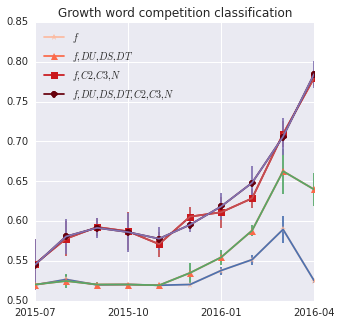

In [451]:
# same but with feature analysis/ablation
scaler = MinMaxScaler()
stat_combos = [
    ['f'],
    ['f', 'DU', 'DS', 'DT'],
#     ['f', 'C2', 'C3'],
    ['f', 'C2', 'C3', 'N'],
    ['f', 'DU', 'DS', 'DT', 'C2', 'C3', 'N']
]
stat_indices = {'f' : 0, 
                'DU' : 1, 'DS' : 2, 'DT' : 3, 
                'C2' : 4, 'C3' : 5, 'N' : 6}
# plot it out
plt.figure(figsize=(5,5))
cmap = plt.get_cmap('Reds')
markers = ['o', '*', '^', 's']
t_start = min(timesteps)
t_end = max(timesteps)
cv = 5
x_ticks_labels = zip(timesteps, [all_dates[t] for t in timesteps])[::3]
xticks, xlabels = zip(*x_ticks_labels)
ctr = 1
for stat_combo in stat_combos:
#     print('testing stat combo %s'%(stat_combo))
    stat_combo_indices = [stat_indices[stat_name] for stat_name in stat_combo]
    mean_scores = []
    score_errs = []
    for t in timesteps:
        t_str = all_dates[t]
        all_stats_t = all_clean_stats[t_str]
        all_stats_t = [all_stats_t[i] for i in stat_combo_indices]
        X_data = get_data(all_pairs, all_stats_t, stat_combo)
        pair_names = X_data.index.tolist()
        X_data = scaler.fit_transform(X_data)
        X_data = pd.DataFrame(X_data, index=pair_names, columns=stat_combo)
        lr = LogisticRegression()
        scores = cross_val_score(lr, X_data, Y_data, cv=cv)
        mean_score = pd.np.mean(scores)
        mean_scores.append(mean_score)
        score_err = pd.np.std(scores)
        score_errs.append(score_err)
    color = cmap(ctr / len(stat_combos))
    marker = markers[ctr % len(markers)]
    stat_combo_str = '$%s$'%(','.join(stat_combo))
    plt.plot(timesteps, mean_scores, color=color, marker=marker, label=stat_combo_str)
    plt.errorbar(timesteps, mean_scores, yerr=score_errs)
    plt.xticks(xticks, xlabels)
    ctr += 1
plt.title('Growth word competition classification')
plt.legend(loc='upper left')
plt.show()

Frequency on its own doesn't do a lot; it's the combination of frequency and either (1) social or (2) semantic info that better predicts word success.

## Testing frequency predictiveness
How well does the frequency at $t_{n-1}$ predict frequency delta at $t_{n}$? Similar to Altmann et al. (2011) plots; repeat plot across all statistics.

In [ ]:
tf_final = tf.ix[:,1:]
tf_start = tf.ix[:,0:-1]
tf_final.columns = tf_start.columns

## Test different embeddings
Let's try different embedding methods to determine whether one produces more reliable growth word pairs.

In [318]:
# tf_means = pd.read_csv('../../data/frequency/2015_2016_tf_norm.tsv', sep='\t', index_col=0).mean(axis=1)
top_k = 100
top_growth_words = tf_0.loc[growth_words].sort_values(inplace=False, ascending=False)[:top_k]
top_growth_words = top_growth_words.index.tolist()

In [330]:
from collections import defaultdict
import os
embed_types = ['word2vec', 'wang2vec']
dims = [50, 100, 300]
windows = [2, 5, 10]
date_str = '2015-06'
embed_names = ['%s_%s_%d_%d_embeddings'%(date_str, e, d, w) 
               for e in embed_types 
               for d in dims 
               for w in windows]
data_dir = '../../data/embeddings/'
embed_files = [os.path.join(data_dir, e) for e in embed_names]
growth_word_matches = defaultdict(list)
top_k = 10
for embed_name, embed_file in zip(embed_names, embed_files):
    embeddings = Word2Vec.load_word2vec_format(embed_file, binary=True)
    embed_vocab = list(set(growth_words) & set(embeddings.vocab.keys()))
    growth_word_embeddings = pd.DataFrame(pd.np.array([embeddings[v] for v in embed_vocab]),
                                          index=embed_vocab)
    growth_word_sims = cosine_similarity(growth_word_embeddings)
    growth_word_sims = pd.DataFrame(growth_word_sims, index=embed_vocab, columns=embed_vocab)
    for w in top_growth_words:
        match = growth_word_sims.loc[w].sort_values(ascending=False, inplace=False).index[1]
        growth_word_matches[w].append(match)
#         neighbors, sims = zip(*neighbor_sim_pairs)
#         growth_word_sets[w].append(neighbors)

In [432]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# growth_word_matches = pd.DataFrame(growth_word_matches, index=embed_names).transpose()
growth_word_matches

,2015-06_word2vec_50_2_embeddings,2015-06_word2vec_50_5_embeddings,2015-06_word2vec_50_10_embeddings,2015-06_word2vec_100_2_embeddings,2015-06_word2vec_100_5_embeddings,2015-06_word2vec_100_10_embeddings,2015-06_word2vec_300_2_embeddings,2015-06_word2vec_300_5_embeddings,2015-06_word2vec_300_10_embeddings,2015-06_wang2vec_50_2_embeddings,2015-06_wang2vec_50_5_embeddings,2015-06_wang2vec_50_10_embeddings,2015-06_wang2vec_100_2_embeddings,2015-06_wang2vec_100_5_embeddings,2015-06_wang2vec_100_10_embeddings,2015-06_wang2vec_300_2_embeddings,2015-06_wang2vec_300_5_embeddings,2015-06_wang2vec_300_10_embeddings
adulting,feeing,bussy,grandbaby,feeing,puppers,grandbaby,puppers,puppers,grandbaby,bussy,grandbaby,grandbaby,teebo,grandbaby,grandbaby,sandernistas,fgo,puppers
albo,jego,jego,wszystko,tej,jego,masz,teraz,czyli,przed,jego,gdyby,wszystko,wszystko,ludzi,chodzi,wszystko,ludzi,przed
anri,airi,yukimura,riko,subaki,airi,riko,riko,kazuichi,kazuichi,naegi,airi,hiyori,naegi,jolyne,riko,naegi,riko,riko
atago,shigure,shigure,myoko,myoko,myoko,myoko,shigure,myoko,myoko,shigure,shigure,shigure,shigure,myoko,myoko,myoko,myoko,myoko
autothrusters,vessery,vessery,starviper,starviper,vessery,starviper,starviper,starviper,starviper,vessery,vessery,vessery,vessery,vessery,vessery,starviper,vessery,vessery
bacta,zuckuss,zuckuss,zuckuss,dengar,zuckuss,zuckuss,dengar,zuckuss,zuckuss,zuckuss,zuckuss,bossk,dengar,zuckuss,bossk,dengar,zuckuss,zuckuss
battleborn,firewatch,firewatch,firewatch,firewatch,firewatch,firewatch,firewatch,firewatch,firewatch,rottr,firewatch,rottr,firewatch,firewatch,firewatch,firewatch,firewatch,firewatch
birb,miho,puppers,snoot,miho,snoot,puppers,cummies,puppers,puppers,pawg,puppers,mowgli,franku,puppers,bigglesworth,puppers,puppers,puppers
blash,panarin,demko,demko,panarin,panarin,panarin,sheary,panarin,panarin,boeser,boeser,boeser,demko,demko,demko,demko,demko,neuvy
boeser,puljujarvi,fabbri,sanheim,puljujarvi,fabbri,fabbri,puljujarvi,puljujarvi,fabbri,fabbri,fabbri,fabbri,puljujarvi,puljujarvi,fabbri,fabbri,fabbri,fabbri


Even just considering the top growth words, there is not a lot of evidence for competition between growth words. It seems like they're competing more for the same topical attention rather than for grammatical or functional niche.

## Visualize social vs. semantic distinction
Compare the dimensions of {$D_U, D_S, D_T$} x {$C2, C3, P$} for all growth words.

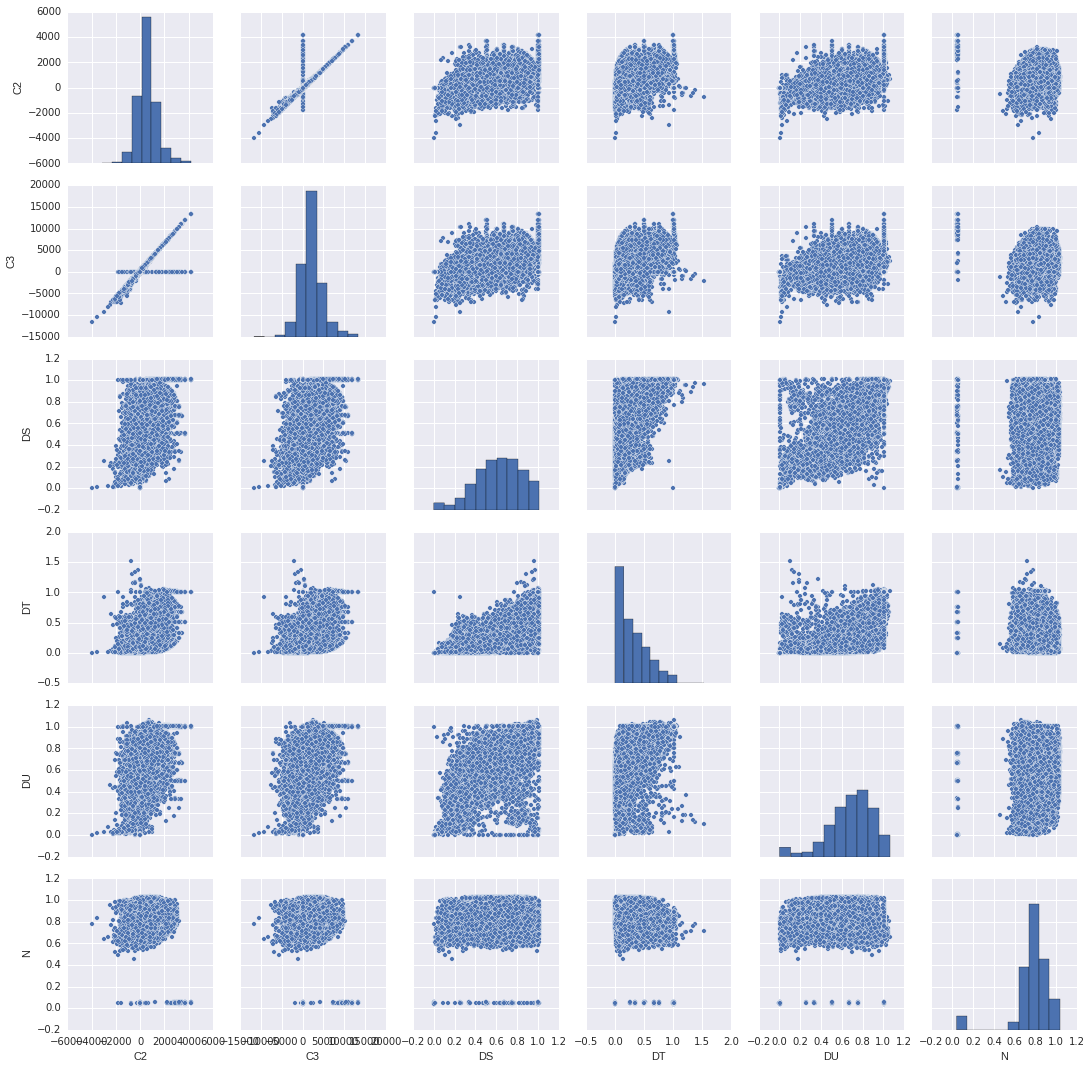

In [443]:
import seaborn as sns
# clean all stats first
def clean_stats(all_stats, vocab):
    cleaned = []
    for s in all_stats:
        s = s.loc[vocab]
        s.fillna(0, inplace=True)
        s_smooth = 1e-1 * s[s > 0].min()
        s = s + s_smooth
        cleaned.append(s)
    return cleaned
social_stats = [user_diffusion.copy(), sub_diffusion.copy(), thread_diffusion.copy()]
semantic_stats = [bigram_resids.copy(), trigram_resids.copy(), nearest_sim.copy()]
social_stats = clean_stats(social_stats, vocab)
semantic_stats = clean_stats(semantic_stats, vocab)
social_stat_names = ['DU', 'DT', 'DS']
semantic_stat_names = ['C2', 'C3', 'N']
all_stat_names = social_stat_names + semantic_stat_names
all_stats = [s.values.flatten() for s in social_stats] + [s.values.flatten() for s in semantic_stats]
all_stats = pd.DataFrame({stat_name : s for stat_name, s in zip(all_stat_names, all_stats)})
plt.figure(figsize=(20,20))
sns.pairplot(all_stats)
plt.show()
# pairgrid = sns.PairGrid(all_stats)
# pairgrid.map_diag(sns.kdeplot)
# pairgrid.map_offdiag(sns.jointplot, cmap="Blues_d")
# plt.show()
# N = len(social_stats) * len(semantic_stats)
# cols = 3
# rows = int(N / cols) + 1
# size = 4
# plt.figure(figsize=(cols * size, rows * size))
# ctr = 1
# for social_stat_name, social_stat in zip(social_stat_names, social_stats):
# #     print('%s %s'%(social_stat_name, str(social_stat.shape)))
#     social_stat = social_stat.values.flatten()
#     for semantic_stat_name, semantic_stat in zip(semantic_stat_names, semantic_stats):
# #         print('%s %s'%(semantic_stat_name, str(semantic_stat.shape)))
#         semantic_stat = semantic_stat.values.flatten()
# #         plt.subplot(rows, cols, ctr)
#         plt.figure(figsize=(5,5))
#         # can't plot all points because overflow
# #         plt.plot(social_stat, semantic_stat) 
#         # bivariate distribution
#         sns.jointplot(x=social_stat, y=semantic_stat, kind='hex', color='k')
#         plt.xlabel('$%s$'%(social_stat_name))
#         plt.ylabel('$%s$'%(semantic_stat_name))
#         ctr += 1
#         plt.show()

## Example of over-diffusion
Compare growth and decline of `fleek` with another growth word with matching frequency. We want to determine whether excessive social/context diffusion led to the decline of `fleek` as compared to another growth word.

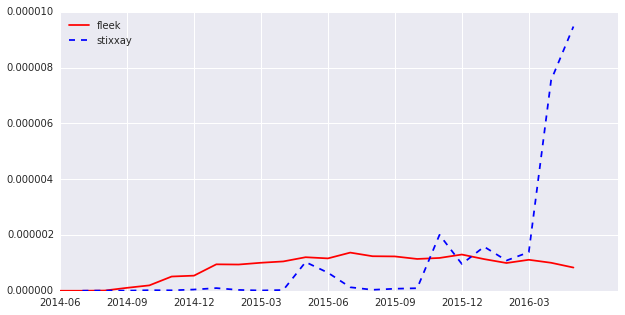

ValueError: x and y must have same first dimension

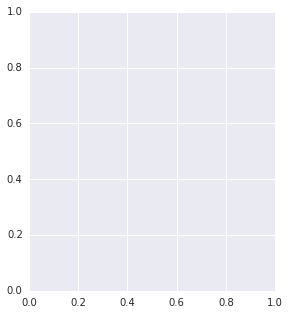

In [452]:
# tf_2014_2015 = pd.read_csv('../../data/frequency/2014_2015_tf_norm.tsv', sep='\t', index_col=0)
# tf_2015_2016 = pd.read_csv('../../data/frequency/2015_2016_tf_norm.tsv', sep='\t', index_col=0)
# tf_2014_2016 = pd.concat([tf_2014_2015, tf_2015_2016], axis=1)
test_word = 'fleek'
match = abs(tf_2015_2016.ix[growth_words, 0] - tf_2015_2016.ix[test_word, 0]).sort_values().index[1]
x_positions = range(tf_2014_2016.shape[1])
xticks, xlabels = zip(*zip(x_positions, tf_2014_2016.columns)[::3])
plt.figure(figsize=(10, 5))
plt.plot(x_positions, tf_2014_2016.loc[test_word], 'r', label=test_word)
plt.plot(x_positions, tf_2014_2016.loc[match], 'b--', label=match)
plt.legend(loc='upper left')
plt.xticks(xticks, xlabels)
plt.show()
# compare with e.g. user diffusion
social_stats = [user_diffusion, sub_diffusion, thread_diffusion]
social_stat_names = ['DU', 'DS', 'DT']
cols = len(social_stats)
rows = 1
plt.figure(figsize=(cols*5, rows*5))
x_positions = range(tf_2015_2016.shape[1])
xticks, xlabels = zip(*zip(x_positions, sorted(tf_2015_2016.columns))[::3])
for i, (social_stat, stat_name) in enumerate(zip(social_stats, social_stat_names)):
    plt.subplot(rows, cols, i+1)
    plt.plot(x_positions, social_stat.loc[test_word], 'r', label=test_word)
    plt.plot(x_positions, social_stat.loc[match], 'b--', label=match)
    plt.legend(loc='upper left')
    plt.title(stat_name)
    plt.xticks(xticks, xlabels)
plt.tight_layout()
plt.show()

Even though `stixxay` got more popular over time, it still remained confined to specific audience while `fleek` remained over-diffuse.

## Solo growth word prediction
What if we just predict the overall growth of individual growth word?